# 权重衰减

上一节中我们观察了过拟合现象，即模型的训练误差远小于它在测试集上的误差。虽然增大训练数据集可能会减轻过拟合，但是获取额外的训练数据往往代价高昂。本节介绍应对过拟合问题的常用方法：权重衰减（weight decay）。


## 方法

权重衰减等价于$L_2$范数正则化（regularization）。正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。我们先描述$L_2$范数正则化，再解释它为何又称权重衰减。

$L_2$范数正则化在模型原损失函数基础上添加$L_2$范数惩罚项，从而得到训练所需要最小化的函数。$L_2$范数惩罚项指的是模型权重参数每个元素的平方和与一个正的常数的乘积。以[“线性回归”](linear-regression.ipynb)一节中的线性回归损失函数

$$\ell(w_1, w_2, b) = \frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right)^2$$

为例，其中$w_1, w_2$是权重参数，$b$是偏差参数，样本$i$的输入为$x_1^{(i)}, x_2^{(i)}$，标签为$y^{(i)}$，样本数为$n$。将权重参数用向量$\boldsymbol{w} = [w_1, w_2]$表示，带有$L_2$范数惩罚项的新损失函数为

$$\ell(w_1, w_2, b) + \frac{\lambda}{2n} \|\boldsymbol{w}\|^2,$$

其中超参数$\lambda > 0$。当权重参数均为0时，惩罚项最小。当$\lambda$较大时，惩罚项在损失函数中的比重较大，这通常会使学到的权重参数的元素较接近0。当$\lambda$设为0时，惩罚项完全不起作用。上式中$L_2$范数平方$\|\boldsymbol{w}\|^2$展开后得到$w_1^2 + w_2^2$。有了$L_2$范数惩罚项后，在小批量随机梯度下降中，我们将[“线性回归”](linear-regression.ipynb)一节中权重$w_1$和$w_2$的迭代方式更改为

$$
\begin{aligned}
w_1 &\leftarrow \left(1- \frac{\eta\lambda}{|\mathcal{B}|} \right)w_1 -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}x_1^{(i)} \left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right),\\
w_2 &\leftarrow \left(1- \frac{\eta\lambda}{|\mathcal{B}|} \right)w_2 -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}x_2^{(i)} \left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right).
\end{aligned}
$$

可见，$L_2$范数正则化令权重$w_1$和$w_2$先自乘小于1的数，再减去不含惩罚项的梯度。因此，$L_2$范数正则化又叫权重衰减。权重衰减通过惩罚绝对值较大的模型参数为需要学习的模型增加了限制，这可能对过拟合有效。实际场景中，我们有时也在惩罚项中添加偏差元素的平方和。

## 高维线性回归实验

下面，我们以高维线性回归为例来引入一个过拟合问题，并使用权重衰减来应对过拟合。设数据样本特征的维度为$p$。对于训练数据集和测试数据集中特征为$x_1, x_2, \ldots, x_p$的任一样本，我们使用如下的线性函数来生成该样本的标签：

$$y = 0.05 + \sum_{i = 1}^p 0.01x_i +  \epsilon,$$

其中噪声项$\epsilon$服从均值为0、标准差为0.01的正态分布。为了较容易地观察过拟合，我们考虑高维线性回归问题，如设维度$p=200$；同时，我们特意把训练数据集的样本数设低，如20。

In [22]:
%matplotlib inline
import d2ltorch as d2lt
import torch
from torch import autograd, nn, optim
from torch.utils import data as tdata

n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn(n_train + n_test, num_inputs)
labels = torch.mm(features, true_w) + true_b
labels += torch.normal(mean=torch.zeros(labels.shape), std=0.01)
labels = labels.reshape(-1, 1)
train_features, test_features = features[: n_train, :], features[n_train:, :]
train_labels, test_labels = labels[: n_train], labels[n_train:]

## 从零开始实现

下面先介绍从零开始实现权重衰减的方法。我们通过在目标函数后添加$L_2$范数惩罚项来实现权重衰减。

### 初始化模型参数

首先，定义随机初始化模型参数的函数。该函数为每个参数都附上梯度。

In [2]:
def init_params():
    w = torch.normal(mean=torch.zeros(num_inputs, 1), std=1)
    b = torch.zeros(1, )
    w.requires_grad_()
    b.requires_grad_()
    return [w, b]

### 定义$L_2$范数惩罚项

下面定义$L_2$范数惩罚项。这里只惩罚模型的权重参数。

In [3]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

### 定义训练和测试

下面定义如何在训练数据集和测试数据集上分别训练和测试模型。与前面几节中不同的是，这里在计算最终的损失函数时添加了$L_2$范数惩罚项。

In [4]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2lt.linreg, d2lt.squared_loss
train_iter = tdata.DataLoader(tdata.TensorDataset(
    train_features, train_labels), batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            # 添加了L2范数惩罚项
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l.backward()
            d2lt.sgd([w, b], lr, batch_size)
        with torch.no_grad():
            train_ls.append(loss(net(train_features, w, b), 
                                 train_labels).mean().item())
            test_ls.append(loss(net(test_features, w, b), 
                                test_labels).mean().item())
    d2lt.semilogy(range(1, num_epochs + 1), train_ls, 'epoch', 'loss',
                  range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

### 观察过拟合

接下来，让我们训练并测试高维线性回归模型。当`lambd`设为0时，我们没有使用权重衰减。结果训练误差远小于测试集上的误差。这是典型的过拟合现象。

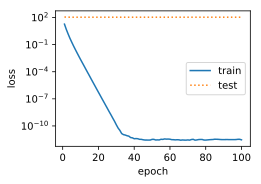

L2 norm of w: 13.74157428741455


In [5]:
fit_and_plot(lambd=0)

### 使用权重衰减

下面我们使用权重衰减。可以看出，训练误差虽然有所提高，但测试集上的误差有所下降。过拟合现象得到一定程度的缓解。另外，权重参数的$L_2$范数比不使用权重衰减时的更小，此时的权重参数更接近0。

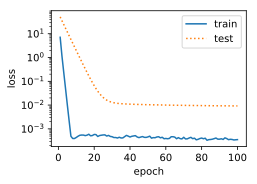

L2 norm of w: 0.03800373896956444


In [6]:
fit_and_plot(lambd=3)

## 简洁实现

这里我们直接在构造`Optimizer`实例时通过`weight_decay`参数来指定权重衰减超参数。默认下，optimizer会对权重和偏差同时衰减。我们分别对权重和偏差设置不同的优化参数，从而只对权重衰减。

In [27]:
def fit_and_plot_nn(wd):
    net = nn.Sequential(nn.Linear(200, 1))
    d2lt.params_init(net, init=nn.init.normal_, std=1)
    
    # 这里提供一个通用的对不同参数分别设置优化参数的方法
    weight_params, bias_params = [], []
    for name, param in net.named_parameters():
        if 'bias' in name:
            bias_params.append(param)
        else if 'weight' in name:
            weight_params.append(param)
    
    # 对权重参数衰减，不对偏差参数衰减。
    optimizer = optim.SGD([
        {'params': weight_params, 'weight_decay': wd},
        {'params': bias_params, 'weight_decay': 0}
    ], lr=lr)
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            net.zero_grad()
            l = loss(net(X), y)
            l.backward()
            # 对Optimizer实例调用step函数，从而分别更新权重和偏差
            optimizer.step()

        with torch.no_grad():
            train_ls.append(loss(net(train_features),
                                 train_labels).mean().item())
            test_ls.append(loss(net(test_features),
                                test_labels).mean().item())
    d2lt.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net[0].weight.data.norm().item())    

与从零开始实现权重衰减的实验现象类似，使用权重衰减可以在一定程度上缓解过拟合问题。

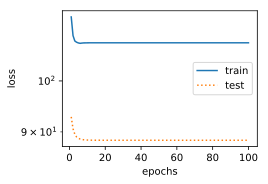

L2 norm of w: 13.69723892211914


In [28]:
fit_and_plot_nn(0)

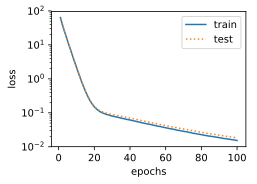

L2 norm of w: 0.050310514867305756


In [29]:
fit_and_plot_nn(3)

## 小结

* 正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。
* 权重衰减等价于$L_2$范数正则化，通常会使学到的权重参数的元素较接近0。
* 权重衰减可以通过optimizer的`weight_decay`超参数来指定。
* 可以对不同的模型参数定义不同的超参数。

## 练习

* 回顾一下训练误差和泛化误差的关系。除了权重衰减、增大训练量以及使用复杂度合适的模型，你还能想到哪些办法来应对过拟合？
* 如果你了解贝叶斯统计，你觉得权重衰减对应贝叶斯统计里的哪个重要概念？
* 调节实验中的权重衰减超参数，观察并分析实验结果。



## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/984)

![](../img/qr_weight-decay.svg)